# Example Taken from Deep Dive to Deep Learning Book
see [original](https://d2l.ai/chapter_computer-vision/image-augmentation.html)

# Image Augmentation


First, import the packages or modules required for the experiment in this section.

In [2]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

## Common Image Augmentation Method

In this experiment, we will use an image with a shape of $400\times 500$ as an example.

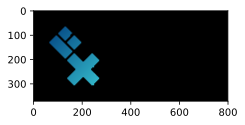

In [9]:
d2l.set_figsize()
img = image.imread('../../images/Logo_HSB_Hochschule_Bremen.png')
d2l.plt.imshow(img.asnumpy())

The drawing function `show_images` is defined below.

In [10]:
# This function is saved in the d2l package for future use
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, we next define the auxiliary function `apply`. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all results.

In [11]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### Flip and Crop

Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation. Next, we use the `transforms` module to create the `RandomFlipLeftRight` instance, which introduces a 50% chance that the image is flipped left and right.

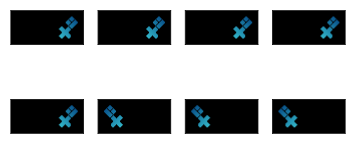

In [12]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

Flipping up and down is not as commonly used as flipping left and right. However, at least for this example image, flipping up and down does not hinder recognition. Next, we create a `RandomFlipTopBottom` instance for a 50% chance of flipping the image up and down.

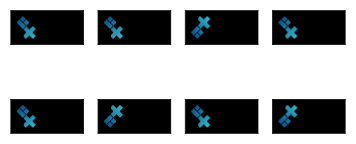

In [13]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())



In the following code, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise stated, the random number between $a$ and $b$ in this section refers to a continuous value obtained by uniform sampling in the interval $[a,b]$.

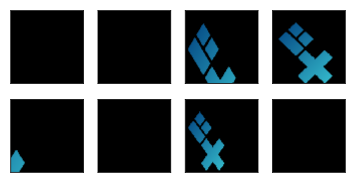

In [14]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Change Color

Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.

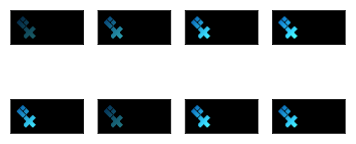

In [15]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

Similarly, we can randomly change the hue of the image.

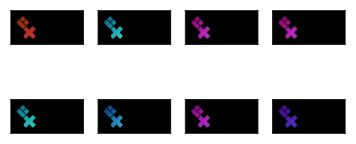

In [16]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

We can also create a `RandomColorJitter` instance and set how to randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time.

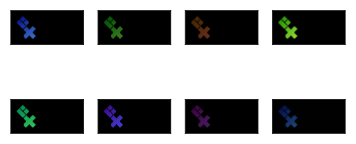

In [17]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Overlying Multiple Image Augmentation Methods

In practice, we will overlay multiple image augmentation methods. We can overlay the different image augmentation methods defined above and apply them to each image by using a `Compose` instance.

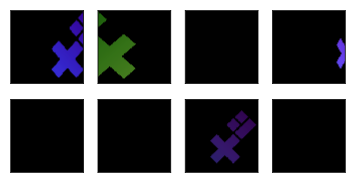

In [18]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

## Using an Image Augmentation Training Model

Next, we will look at how to apply image augmentation in actual training. Here, we use the CIFAR-10 data set, instead of the Fashion-MNIST data set we have been using. This is because the position and size of the objects in the Fashion-MNIST data set have been normalized, and the differences in color and size of the objects in CIFAR-10 data set are more significant. The first 32 training images in the CIFAR-10 data set are shown below.

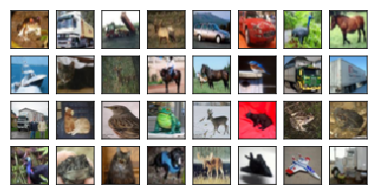

In [19]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

In order to obtain a definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction. Here, we only use the simplest random left-right flipping method. In addition, we use a `ToTensor` instance to convert mini-batch images into the format required by MXNet, i.e. 32-bit floating point numbers with the shape of (batch size, number of channels, height, width) and value range between 0 and 1.

In [20]:
train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor()])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()])

Next, we define an auxiliary function to make it easier to read the image and apply image augmentation. The `transform_first` function provided by Gluon's data set applies image augmentation to the first element of each training example (image and label), i.e., the element at the top of the image. For detailed description of `DataLoader`, refer to the previous ["Image Classification Data Set (Fashion-MNIST)"](fashion-mnist.md) section.

In [21]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

### Using a Multi-GPU Training Model

We train the ResNet-18 model described in ["ResNet"](../chapter_convolutional-neural-networks/resnet.md) section on the CIFAR-10 data set. We will also apply the methods described in the ["Concise Implementation of Multi-GPU Computation"](../chapter_computational-performance/multiple-gpus-gluon.md) section, and use a multi-GPU training model.

First, we define the `try_all_gpus` function to get all available GPUs.

In [22]:
# This function has been saved in the d2l package for future use
def try_all_gpus():
    ctxes = []
    try:
        # Assume that the number of GPUs on a machine does not exceed 16
        for i in range(16):
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

The auxiliary function `_get_batch` defined below divides the mini-batch data instance `batch` and copy the batches to each GPU contained in the `ctx` variable.

In [23]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    # When ctx contains multiple GPUs, mini-batch data instances are divided
    # and copied to each GPU.
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

Then, we define the `evaluate_accuracy` function to evaluate the classification accuracy of the model. Different from `evaluate_accuracy`, the function described in the ["Softmax Regression Starting from Scratch"](../chapter_deep-learning-basics/softmax-regression-scratch.md) and ["Convolutional Neural Network (LeNet)"](../chapter_convolutional-neural-networks/lenet.md) sections, the function defined here are more general. It evaluates the model using all GPUs contained in the `ctx` variable by using the auxiliary function `_get_batch`.

In [24]:
# This function has been saved in the d2l package for future use
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n

Next, we define the `train` function to train and evaluate the model using multiple GPUs.

In [25]:
# This function has been saved in the d2l package for future use
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

Now, we can define the `train_with_data_aug` function to use image augmentation to train the model. This function obtains all available GPUs and uses Adam as the optimization algorithm for training. It then applies image augmentation to the training data set, and finally calls the `train` function just defined to train and evaluate the model.

In [26]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

Now we train the model using image augmentation of random flipping left and right.

In [ ]:
train_with_data_aug(train_augs, test_augs)

training on [cpu(0)]


## Summary

* Image augmentation generates random images based on existing training data to cope with overfitting.
* In order to obtain a definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction.
* We can obtain classes related to image augmentation from Gluon's `transforms` module.

## Exercises

* Train the model without using image augmentation: `train_with_data_aug(no_aug, no_aug)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
* Add different image augmentation methods in model training based on the CIFAR-10 data set. Observe the implementation results.
* With reference to the MXNet documentation, what other image augmentation methods are provided in Gluon's `transforms` module?

